# Product Detection - Shopee

In [1]:
from numpy.random import seed
seed(101)
from tensorflow import random
random.set_seed(101)

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. Data Preparation

In [3]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


### > Data Training dan Validation

<p>
Membuat data training dan data validation menggunakan ImageDataGenerator dan flow_from_directory. Dataset train dibagi menjadi
80% untuk data training dan 20% untuk data validation. Kedua data ini digunakan ketika proses training model berlangsung.
Data training dan validation dapat dilihat secara langsung pada folder dengan lokasi 'dataset/train'
</p>

In [4]:
TrainImageGen = ImageDataGenerator(rotation_range=45, width_shift_range=0.1, height_shift_range=0.1, 
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest', 
                                   horizontal_flip=True, rescale=1/255, validation_split=0.2, )

In [5]:
trainSet = TrainImageGen.flow_from_directory('dataset/train/', subset='training', target_size=(256, 256), seed=101)

Found 1360 images belonging to 17 classes.


In [6]:
validationSet = TrainImageGen.flow_from_directory('dataset/train/', subset='validation', target_size=(256, 256), seed=101)

Found 340 images belonging to 17 classes.


### > Data Testing

<p>
Membuat data testing menggunakan ImageDataGenerator dan flow_from_directory. Data ini nantinya digunakan untuk menguji 
model yang telah melalui proses training. Data training dan validation dapat dilihat secara langsung pada folder dengan lokasi 'dataset/test'
</p>

In [7]:
TestImageGen = ImageDataGenerator(rescale=1/255.)

In [8]:
testSet = TestImageGen.flow_from_directory('dataset/test/', class_mode=None,
                                           shuffle=False, batch_size=1,
                                           target_size=(256, 256), seed=101)

Found 85 images belonging to 1 classes.


## 2. Modeling

### > Neural Network Modeling

<p>
Dalam pemodelan layer digunakan Conv2D, MaxPooling2D, Flatten, Dense, Dropout. Digunakan metode try and error hingga menemukan model
yang cukup baik.
</p>

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [10]:
model = Sequential ([
    
    Conv2D(filters=32, kernel_size=(3,3), input_shape=(256,256,3), activation='relu'),
    MaxPooling2D(pool_size=(3,3)),
    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(3,3)),
    
    Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(3,3)),
    
    Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(3,3)),
    
    Flatten(),
    
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    
    Dense(17, activation='sigmoid')
    
])

### > Optimizers

<p>
Optimizers yang digunakan untuk proses training model yaitu RMSprop dan Adam.
Kedua optimizer tersebut nantinya akan dibandingkan peforma selama proses training dan
peforma ketika proses evaluation.
</p>

In [11]:
from keras.optimizers import RMSprop, Adam

In [12]:
optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### > Model Training

<p>
    Proses training model mengunakan data training dan data validation. Menggunakan tiga parameter callbacks, yaitu 
    TensorBoard, ModelCheckpoint, EarlyStopping. tiga parameter callbacks tersebut untuk mengontrol proses training,
    sehingga meminimalkan terjadinya overfitting dan underfitting. TensorBoard untuk visualisasi val_loss dan val_accuracy
    setiap epoch proses training. ModelCheckpoint untuk menyimpan model terbaik yang didapatkan selama proses training.
    EarlyStopping untuk menghentikan proses training jika model sudah cenderung overfitting atau underfitting.
</p>

In [13]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

In [14]:
tensorboard = TensorBoard(log_dir = ".\logs\model_Adam_02", profile_batch=0)

checkpoint = ModelCheckpoint(".\checkpoints\model_Adam_02", 
                             monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

earlystopping = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1)

batch_size = 64

model.fit_generator(trainSet, epochs=100, steps_per_epoch=len(trainSet.filenames) // batch_size,
                    validation_data=validationSet, validation_steps=len(validationSet.filenames) // batch_size, 
                    callbacks =[tensorboard, checkpoint, earlystopping])

Epoch 1/100
21/21 [==============================] - 75s 4s/step - loss: 2.8384 - accuracy: 0.0549 - val_loss: 2.8285 - val_accuracy: 0.0625

Epoch 00001: val_accuracy improved from -inf to 0.06250, saving model to .\checkpoints\model_Adam_02
Epoch 2/100
21/21 [==============================] - 50s 2s/step - loss: 2.8296 - accuracy: 0.0506 - val_loss: 2.8215 - val_accuracy: 0.0875

Epoch 00002: val_accuracy improved from 0.06250 to 0.08750, saving model to .\checkpoints\model_Adam_02
Epoch 3/100
21/21 [==============================] - 51s 2s/step - loss: 2.7868 - accuracy: 0.0671 - val_loss: 2.7526 - val_accuracy: 0.0946

Epoch 00003: val_accuracy improved from 0.08750 to 0.09459, saving model to .\checkpoints\model_Adam_02
Epoch 4/100
21/21 [==============================] - 44s 2s/step - loss: 2.6858 - accuracy: 0.1354 - val_loss: 2.7736 - val_accuracy: 0.1500

Epoch 00004: val_accuracy improved from 0.09459 to 0.15000, saving model to .\checkpoints\model_Adam_02
Epoch 5/100
21/21 [

#### >> Model Training Results (RMSprop Optimizer)

<p>
    Berikut ini adalah tampilan grafik yang menunjukan nilai val_accuracy setiap epoch selama proses training berlangsung. Dari grafik tersebut dapat diketahui bahwa model mencapai nilai akurasi validation (val_accuracy) tertinggi pada epoch/step 73, dengan waktu 56 emnit 18 detik dengan nilai val_accuracy sebesar 0.84 atau 84%. Nah model pada epoch/step inilah yang disimpan sebagai model terbaik dengan menggunakan parameter ModelCheckpoint. Proses pelatihan berhenti pada epoch 93, karena model tidak dapat memperoleh val_accuracy terbaik kembali setelah ditunggu 20 epoch (patience=20) dengan menggunakan parameter EarlyStopping.
</p>

<div align="center">
    <img src="Screenshot2.png" width=1000 height=500>
</div>

#### >> Model Training Results (Adam Optimizer)

<p>
    Berikut ini adalah tampilan grafik yang menunjukan nilai val_accuracy setiap epoch selama proses training berlangsung. Dari grafik tersebut dapat diketahui bahwa model mencapai nilai akurasi validation (val_accuracy) tertinggi pada epoch/step 92, dengan waktu 1 jam 10 menit dengan nilai val_accuracy sebesar 0.81 atau 81%. Nah model pada epoch/step inilah yang disimpan sebagai model terbaik dengan menggunakan parameter ModelCheckpoint. Proses pelatihan berhenti pada epoch 100 (epoch maksimal yang ditentukan untuk proses training).
</p>

<div align="center">
    <img src="Screenshot1.png" width=1000 height=500>
</div>

#### >> Validation Accuracy - Model Adam Optimizer vs Model RMSprop Optimizer

<div align="center">
    <img src="Screenshot3.png" width=1000 height=500>
</div>

## 3. Evaluation

### > Load Best Model

<p>
    Model terbaik yang diperoleh pada proses training akan dievaluasi menggunakan data testing. Model terbaik, baik dari model yang menggunakan optimizer Adam maupun RMSprop tersimpan dalam folder checkpoints
</p>

In [15]:
from keras.models import load_model

In [129]:
BestModel = load_model('checkpoints/model_Adam_02')

### > Predict Data Testing

<p>
Data testing yang digunakan untuk menguji model disini benar-benar tidak memiliki label, kita hanya bisa tahu gambar tersebut secara visual.
Sehingga untuk menilai berhasil tidaknya suatu model dalam memprediksi data testing, hanya bisa dengan menilai secara langsung yaitu
mencocokan label kelas & probabilitas kelas dengan setiap gambar yang ada di data testing. Berikut adalah proses dan hasil prediksi model
terhadap data testing.
</p>

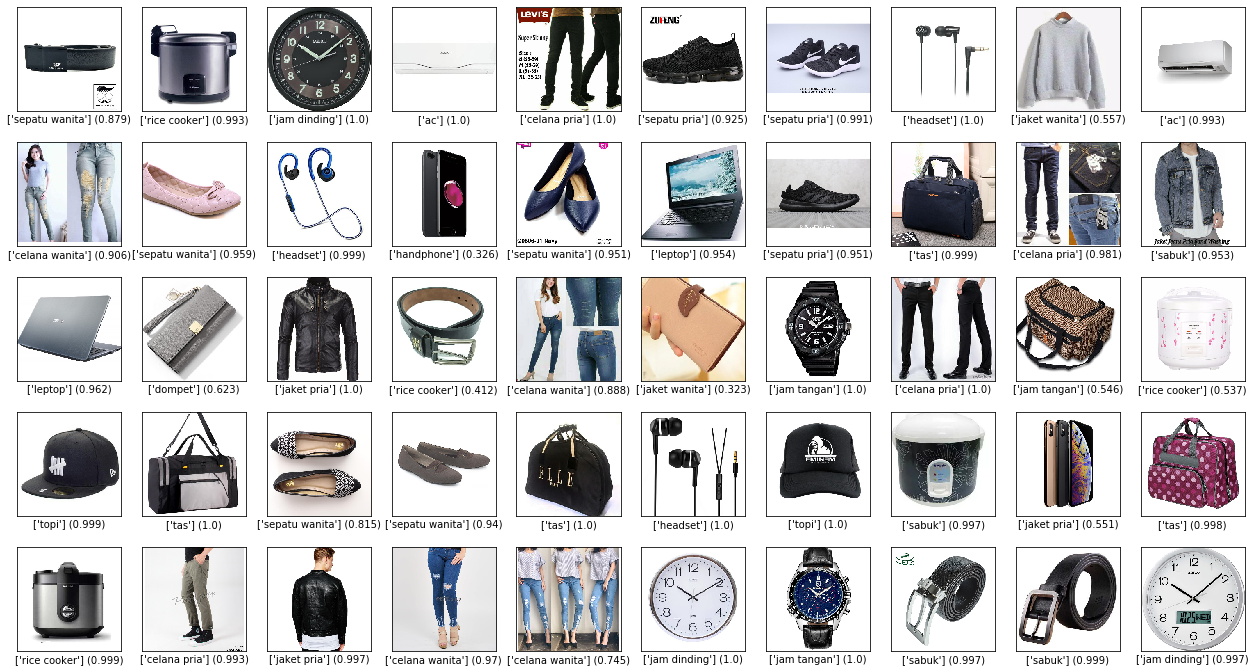

In [130]:
list_images = range(0,len(testSet))
img_indices = random.sample(list_images, 50)

plt.figure(figsize=(22,12))
x = 1
for i in img_indices:
    sample_test_images = testSet[i]

    predictions = BestModel.predict(sample_test_images)

    max_prediction = np.argmax(predictions, axis=1)
    labels = (trainSet.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    prediction_class = [labels[k] for k in max_prediction]

    prediction_probs = np.max(predictions, axis=1)

    plt.subplot(5,10,x)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')

    plt.imshow(sample_test_images[0])
    plt.xlabel('{} ({})'.format(str(prediction_class), str(round(float(prediction_probs),3))))
    x += 1